In [ ]:
import numpy as np
from sklearn import datasets
import numpy.linalg as la 
import matplotlib.pyplot as plt

In [4]:
% matplotlib notebook

In [ ]:
X, y = datasets.load_breast_cancer(return_X_y=True)

### (1) Code up Random Feature approximation for the kernels below:

(a) $k(x, y) = e^{-\frac{\|x - y\|^2}{2 \sigma^2}}$ 


__Solution__:

\begin{align*}
    k(x, y) & \approx \dfrac{1}{m} \sum_{i = 1}^m \langle \phi(x, w_i, b_i),  \phi(y, w_i, b_i) \rangle &w_i \sim N(0, 1/\sigma^2), b \sim Unif(-\pi, \pi) \\
    k(x, y) & \approx \dfrac{1}{m} \sum_{i = 1}^m \langle \cos{w_i'x + b_i},  \cos{w_i'y + b_i} \rangle
\end{align*}




In [ ]:
def gaus_k(x, y, sigma):
    return np.exp(-la.norm(x - y) ** 2 / (2 * sigma ** 2))

def rand_gaus_k(x, y, sigma, num_features=100):
    W = np.random.normal(0, 1 / sigma ** 2 ,  (num_features, len(x)))
    b = np.random.uniform(-np.pi, np.pi, num_features)
    phi_x = np.cos(W @ x + b)
    phi_y = np.cos(W @ y + b)
    return (phi_x @ phi_y) / num_features

In [ ]:
x = np.random.randn(10, 1)
y = np.random.randn(10, 1)
# np.random.seed(10)

# increase the number of features
num_features = 100000
sigma = 2

real_k = gaus_k(x, y, sigma)
est_k = rand_gaus_k(x, y, sigma, num_features)

print(la.norm(real_k - est_k))

(b) $k_n(x, y) = \dfrac{1}{\pi}\|x\|^n \|y\|^n J_n(\theta), \; \; \theta = \arccos{\dfrac{x'y}{\|x\| \|y\|}}$

__Solution__: We will approximate the kernel when $n = 1.$ When $n = 1, J_1(\theta) = \sin{\theta} + (\pi - \theta) \cos{\theta}.$ So,

$$
 k_1(x, y) = \dfrac{1}{\pi} \|x\| \|y\| (\sin{\theta} + (\pi - \theta) \cos{\theta})
$$

\begin{align*}
    k_1(x, y) & \approx \dfrac{1}{m} \sum_{i = 1}^m \langle \sigma(w_i'x), \sigma(w_i'y) \rangle & \sigma(x)= \max(x, 0), w_i \sim N(0, 1) 
\end{align*}

In [ ]:
def arc_cos_k(x, y):
    theta = np.arccos((x @ y) / (la.norm(x) * la.norm(y)))
    J_theta = np.sin(theta) + ((np.pi - theta) * np.cos(theta))
    return (1 / np.pi) * la.norm(x) * la.norm(y) * J_theta

def rand_arc_cos_k(x, y, num_features=100):
    W = np.random.normal(0, 1, (num_features, len(x)))
    phi_x = np.maximum(W @ x, 0)
    phi_y = np.maximum(W @ y, 0)
    return (phi_x @ phi_y) / num_features * 2

In [ ]:
x = np.random.randn(10, )
y = np.random.randn(10, )
# np.random.seed(10)

# increase the number of features
num_features = 100


real_k = arc_cos_k(x, y)
est_k = rand_arc_cos_k(x, y, num_features)

print(real_k, est_k)

## Pick a dataset and run a kernalized ridge regression on it to produce an error vs regularizer plot 

Given a dataset $X \in R^{N \times d}, y \in R^{N \times 1}$, we are trying to learn $f^* \in H$ such that

\begin{equation*}
 f^* = argmin_{h \in H} \dfrac{1}{2}\sum_{i=1}^N (h(x_i) - y_i)^2 + \dfrac{\lambda}{2} \|f\|_H^2
\end{equation*}

By the representer theorem, we get that 
\begin{align*}
    f^* &= \dfrac{1}{2} argmin_{\alpha \in R^N} \sum_{i=1}^{N} \big( \sum_{j=1}^N \alpha_j k(x_j, x_i) - y_i \big)^2 + \dfrac{\lambda}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha_i \alpha_j k(x_i, x_j) \\ 
    \\
    &= argmin_{\alpha \in R^N} \dfrac{1}{2}  \|K \alpha - y\|_2^2 + \dfrac{\lambda}{2} \alpha^T K \alpha & K \in R^{N \times N}, \alpha \in R^{N \times 1}
\end{align*}

In order to find the minimizer, we can take the derivative and set it equal to 0.

\begin{align*}
 & \nabla_\alpha \big(\dfrac{1}{2}\| K \alpha - y\|_2^2 + \dfrac{\lambda}{2} \alpha^T K \alpha \big)= 0 \\
 & \implies K(K\alpha - y) + \lambda K \alpha = 0 \\
 & \implies K(K \alpha +  \lambda I \alpha) = KY \\
 & \implies (K + \lambda I) \alpha = Y \\
 & \implies \alpha = (K + \lambda I)^{-1} Y
\end{align*}

In [ ]:
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.model_selection import train_test_split

In [ ]:
X, y = datasets.load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=46)

In [ ]:
# D = 1000 # num of random features
score_list = []
lamda_list = np.logspace(-8,4,9) #[1, 0.1, 0.01, 0.001, 0.0001]
sigma = 1000 # bandwidth of the kernel
for lamda in lamda_list:
#     sigma = 2 # bandwidth of the kernel

    # train
    K = np.exp(-squareform(pdist(X_train, 'euclidean')) ** 2 / (2 * sigma**2))
    alpha = la.solve(K + np.eye(len(K)) * lamda, y_train)

    # test
    c = np.exp(-(cdist(X_test, X_train, 'euclidean')) ** 2 / (2 * sigma ** 2))
    pred = c @ alpha
    score = la.norm(pred - y_test)
    
    score_list.append(score)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.semilogx(lamda_list, score_list)

print(pred[:10])

In [ ]:
# testing to see that the results match sklearn kernel ridge regression implementation
from sklearn.kernel_ridge import KernelRidge

score_list = []
lamda_list = [1, 0.1, 0.01, 0.001, 0.0001]
for lamda in lamda_list:
    clf = KernelRidge(alpha=lamda, kernel='rbf', gamma=1 / (2 * sigma ** 2))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    score = la.norm(pred - y_test)
    
    score_list.append(score)
# print(score_list)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(lamda_list, score_list)

print(pred[:10])

## Compare the $\dfrac{1}{\sqrt{K}}$ approximation rate from approximation kernels with random fourier features

We want to see whether the error between the actual kernel and the random fourier approximation scheme decreases at the order of $\dfrac{1}{\sqrt K}$. Given a dataset $X$, we will generate

\begin{align*}
    K_{i, j} &= e^{\dfrac{-\| x_i - x_j \|}{2 \sigma^2}} \\
    \hat{K}_{i, j} &= \dfrac{1}{K}\sum_{l=1}^K \langle \cos{w_l'x_i + b_l}, \cos{w_l'x_j + b_l} \rangle &w_l \sim N(0,1), b_l \sim Unif(0, 2 * pi)
\end{align*}

Then, we will compare the frobenius norm between these matrices. As $K$ increases, the log-log plot of the error should have the same slope as $\dfrac{1}{\sqrt K}.$

In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [6]:
#X, y = datasets.load_breast_cancer(return_X_y=True)
X = np.random.randn(800,10)

sigma = .1
err_list = []

num_features = np.round(np.logspace(1, 5, 14)).astype(int)
for D in num_features:
    d = X.shape[1] # dim of data
    # K_hat
    W = np.random.normal(0, 1, (D, d)) / sigma
    b = np.random.uniform(-np.pi, np.pi, (D, 1))
    phi = np.cos(W @ X.T + b)
    K_hat = 1 / D * phi.T @ phi
    # real K matrix
    K = np.exp(-squareform(pdist(X, 'euclidean')) ** 2 / (2 * sigma **2))
    
    err = la.norm(K - K_hat, 'fro') / K.shape[0]**2
    err_list.append(err)

<IPython.core.display.Javascript object>


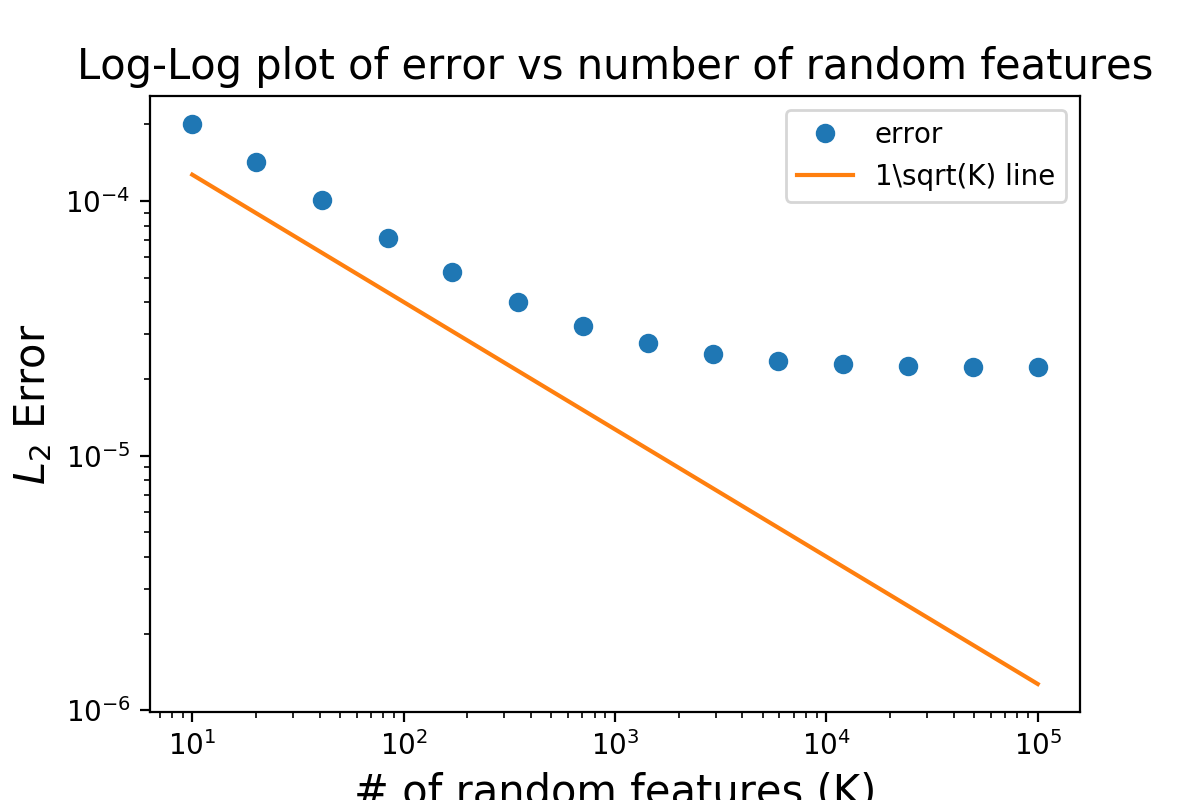

In [8]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
plt.loglog(num_features, err_list, 'o', label='error')
plt.loglog(num_features, err_list[0] * 2/np.sqrt(num_features), label='1\sqrt(K) line')
plt.title('Log-Log plot of error vs number of random features', fontsize=15)
plt.xlabel('# of random features (K)', fontsize=15)
plt.ylabel(r'$L_2$ Error', fontsize=15)
plt.legend()